In [72]:
import pydot
import random
import math
import matplotlib.pyplot as plt
import networkx as nx
import math
from statistics import mean 
from collections import Counter

## Retrieving data

### Parsing dot file

In [2]:
def parse_dot_file(file_path):
    graph = pydot.graph_from_dot_file(file_path)[0]  # Get the first graph from the list
    nodes = []
    edges = []
    for node in graph.get_nodes():
        nodes.append(node.get_name())
    for edge in graph.get_edges():
        source = edge.get_source()
        target = edge.get_destination()
        attributes = edge.get_attributes()
        edges.append((source, target, attributes))
    return nodes, edges

file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/noname.dot"
#LesMiserables, LeagueNetwork, polblogs, JazzNetwork, noname
nodes, edges = parse_dot_file(file_path)

# print("Nodes:", nodes)
# print("Edges:")
# for edge in edges:
#     print(edge)


## Analyzing the edges

In [3]:
'''Edges+Nodes -> Adjacency matrix'''
num_nodes = len(nodes)
adj_matrix = [[0] * num_nodes for _ in range(num_nodes)]

for i, edge in enumerate(edges):
    source = edge[0]
    target = edge[1]
    weight = edge[2]
    try:
        adj_matrix[nodes.index(source)][nodes.index(target)] = weight['weight']
    except KeyError:
        adj_matrix[nodes.index(source)][nodes.index(target)] = 0
        

print("Adjacency Matrix:")
print(nodes)
print(adj_matrix)

'''writing the nodes and the edges on a txt file'''
with open('adjacency_matrix.txt', 'w') as file:
    for item in adj_matrix:
            file.write(" ".join(map(str,item)))
            file.write("\n")

Adjacency Matrix:
['5', '13', '3', '6', '14', '15', '7', '11', '8', '9', '16', '10', '4', '2', '18', '17', '19', '20', '12', '21', '22', '1', '23', '24']
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
'''Read adjacency matrix from the text file'''
def read_adjacency_matrix(file_path):
    # Read the text file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Process each line
    adjacency_matrix = []
    for line in lines:
        # Split the line by spaces, remove whitespace characters, convert to integers
        nums = [int(num) for num in line.strip().split()]
        # Append the list of integers to the result
        adjacency_matrix.append(nums)
    return adjacency_matrix

        
adjacency_matrix = read_adjacency_matrix("adjacency_matrix.txt")
print(adjacency_matrix)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [5]:
'''Adjacency Matrix (undirected) edge countings for each node'''
# vertical_list = [] #target based
# horizontal_list = [] #source based
# for index, x in enumerate(adjacency_matrix):
#     vertical_count = 0
#     for y in adj_matrix:
#         vertical_count += y[index]
#     vertical_list.append(vertical_count)
#     horizontal_list.append(x.count(1))
    
# print(vertical_list)
# print(horizontal_list)
# total_edge_countings = [vertical_list[i]+horizontal_list[i] for i in range(len(vertical_list))]
# print(total_edge_countings)

'Adjacency Matrix (undirected) edge countings for each node'

## Step 1: Basic MatplotLib Graph Drawing

The perfect structure (drawing conventions):
- Edges vertical/horizontal
- Symmetry
- Minimal graph size
- Maximal simple open curves
- Stress of layout (backpath not too long/too short)

The tree structure:
- Equal Distances between vertices
- Layered

goals (quality metrics):
- Minimum number of slopes
- Minimum number of corners bends
- Minimum intersections

In [6]:
# Function to arrange nodes in a square-like layout
def arrange_in_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))
    spacing = 50
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y)
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row
    return node_positions

def arrange_in_radial(nodes):
    num_nodes = len(nodes)
    radius = 200
    angle_step = 360 / num_nodes
    node_positions = {}
    for i, node in enumerate(nodes):
        angle = math.radians(i * angle_step)
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        node_positions[node] = (x, y)
    return node_positions

def arrange_in_semi_square(nodes):
    num_nodes = len(nodes)
    side_length = int(math.ceil(math.sqrt(num_nodes)))  # Calculate the side length of the square
    spacing = 60  # Spacing between nodes
    start_x, start_y = -((side_length - 1) * spacing) / 2, ((side_length - 1) * spacing) / 2
    node_positions = {}
    current_x, current_y = start_x, start_y
    for i, node in enumerate(nodes):
        node_positions[node] = (current_x, current_y + random.randint(-15, 15))
        current_x += spacing

        if (i + 1) % side_length == 0:
            current_x = start_x
            current_y -= spacing  # Move to the next row

    return node_positions

In [268]:
def draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size=300): 
    fig, ax = plt.subplots()
               
    # Draw nodes and labels
    for node, pos in node_positions.items():
        if 'd' in node: #if it is a dummy
            ax.scatter(pos[0], pos[1], s=node_size/2, color=node_colors[node], edgecolors='black', zorder=5, marker="s")  # Draw node
        else:
            ax.scatter(pos[0], pos[1], s=node_size, color=node_colors[node], edgecolors='black', zorder=5)  # Draw node
        ax.text(pos[0], pos[1], node[0:4], ha='center', va='center', fontsize=8, zorder=10)  # Add label
        
    # Draw edges
    for edge in edges:
        source, target, _ = edge
        start = node_positions[source]
        end = node_positions[target]
        if 'd' in source: #if it is a dummy
            original_source = source
            while 'd' in original_source:
                original_source = [other_source for other_source, other_target, weight in edges if other_target == source][0]
                source = original_source
            ax.plot([start[0], end[0]], [start[1], end[1]], color=node_colors[original_source], zorder=0)  # Draw edge
        else:
            ax.plot([start[0], end[0]], [start[1], end[1]], color=node_colors[source], zorder=0)  # Draw edge
        
    plt.show()

## Step 1: Discussion

The Graph drawing shows a complexity of Linear time, meaning O(log n), because it shows no nested loops nor have logarithm time complexity in each operation. Because of the use of the Turtle library, more Nodes can easily be added and because of the complex libary, there are a lot of extra handy functions to improve the layout of the graph. But because the turtle manually writes to the screen, meaning it is a color written paper meaning each node nor edges are not interactive at all. 

As a bonus algorithm, both semi-squared and circle are implemented to show that the structure really matters how the layout is build. The semi-squared layout shows what happens when each node random moves from the vertical line and improves the layout, because you can now identify edges that are in the same vertical line. The circle layout

## Step 2: Tree based algorithm



### Tree structure

In [8]:
# It is easier to use layered tree structure to visualize both DFS and BFS
def arrange_in_tree(nodes, edges, root=None):
    def create_initial_tree(nodes, edges, root, tree=0):
        num_nodes = len(nodes)
        node_positions = {}
        if root == None:
            root = nodes[0]

        node_positions[root] = ((3*tree), 0)
        layer_space = 1
        node_space = 1
        padding = 10

        queue = [root]
        past_nodes = []
        '''Tree creation'''
        while queue != []:
            current_node = queue[0]
            connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
            children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in past_nodes]
            if children_nodes != []: 
                segment_length = node_space / len(children_nodes)
                parent_coords = node_positions[current_node]
                for i, children_node in enumerate(children_nodes):
                    if children_node not in node_positions:
                        new_x = -node_space/2+segment_length*(0.5+i) + (3 * tree)
                        new_y = parent_coords[1]-layer_space
                        node_positions[children_node] = (new_x, new_y)
                queue = children_nodes + queue
            queue.remove(current_node)
            past_nodes.append(current_node)
        return queue, past_nodes, node_positions, root
    
    nodes_left = nodes.copy()
    tree = 0
    full_node_positions = {}
    root_list = []
    while nodes_left != []:
#     for x in range(2):
        queue, past_nodes, node_positions,root = create_initial_tree(nodes_left, edges, root, tree)
        full_node_positions.update(node_positions)
        nodes_left = [x for x in nodes_left if x not in past_nodes]
        root_list.append(root)
        root = None
        tree = tree + 1

        
    '''Improve node positions in tree '''
    #this part will calculate what the max and min x&y-coordinate for the graph to determine the most rightest & leftest etc. place
    layer_min_max = {} 
    for node, node_pos in full_node_positions.items():
        layer = node_pos[1] #y-as
        x_coord = node_pos[0] #x-as
        if layer not in layer_min_max:
            layer_min_max[layer] = [x_coord, x_coord]
        else:
            if x_coord < layer_min_max[layer][0]:
                layer_min_max[layer][0] = x_coord
            if x_coord > layer_min_max[layer][1]:
                layer_min_max[layer][1] = x_coord

    # Move nodes which are already in the same layer and divide them equally through the layer
    for layer, (min_x, max_x) in layer_min_max.items():
        layer_nodes = [(node, pos) for node, pos in full_node_positions.items() if pos[1] == layer]
#         if len(layer_nodes) > 5:
        if len(layer_nodes) > 2: #TODO fix visual
            interval = (max_x - min_x) / (len(layer_nodes) - 1)
            for i, (node, pos) in enumerate(layer_nodes):
                new_x = min_x + i * interval
                full_node_positions[node] = (new_x, pos[1])
#             print(node_positions)
        elif layer_nodes[0][1][1] < 0: #check if not first layer and not a lot of nodes, connected them with their parents by giving the parent's node x-as
            for i, layer_node in enumerate(layer_nodes):
                parent_node = [parent_node[0] for parent_node in edges if parent_node[1] == layer_node[0]]
                if parent_node != []:
                    middle_parent_node_coords = mean([parent_node_coords[1][0] for parent_node_coords in previous_layer_nodes if parent_node_coords[0] in parent_node])
                    full_node_positions[layer_node[0]] = (middle_parent_node_coords, layer_node[1][1])
        layer_nodes = [(node, pos) for node, pos in full_node_positions.items() if pos[1] == layer]        
        previous_layer_nodes = layer_nodes.copy()
    return full_node_positions

### Search Algorithms

In [9]:
def search_through_tree(nodes, edges, node_positions, node_colors, search_root=None, node_size=200):
    org_edges = edges.copy() #saves the original edges
    print("DFS:")
    '''DFS'''
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    stack = [search_root]
    visited = []
    DFS_edges = []
    while stack != []:
        current_node = stack[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in visited]        
        if children_nodes != []:
            for children_node in children_nodes:
                if children_node in stack:
                    stack.remove(children_node)
                stack[stack.index(current_node):stack.index(current_node)] = [children_node]
            for edge in edges:
                if (edge[0] == current_node and edge[1] == children_nodes[0] 
                     and edge[1] not in [elem[1] for elem in DFS_edges]): #same source and if target is first edge
                    DFS_edges.append(edge)
                elif (edge[1] == current_node and edge[0] == children_nodes[0]
                      and edge[0] not in [elem[0] for elem in DFS_edges]): #viceversa cuz undirected
                    DFS_edges.append((edge[1], edge[0], edge[2]))
        elif len(visited) != len(nodes):
            stack.insert(0,[elem[0] for elem in DFS_edges if elem[1] == current_node][0])
        if current_node not in visited:
            visited.append(current_node)
        stack.remove(current_node)
        
    print('Visited', visited)
    DFS_node_positions = arrange_in_tree(nodes, DFS_edges, search_root)
    draw_node_link_diagram(visited, DFS_edges, DFS_node_positions, node_colors, node_size)
    
    '''Restoring original values'''
    print("BFS:")
    '''BFS'''
    BFS_edges = []
    num_nodes = len(nodes)
    if search_root == None:
        search_root = nodes[0]
    queue = [search_root]
    visited = []
    while queue != []:
        current_node = queue[0]
        connected_edges = [t[:2] for t in edges if current_node in t[:2]] 
        connected_edges = sorted(connected_edges, key=lambda x: int(x[1]))
        children_nodes = [value for tuple in connected_edges for value in tuple if value != current_node and value not in visited]
        if children_nodes != []:
            for children_node in children_nodes:
                if children_node not in queue:
                    queue.append(children_node)
                for edge in edges:
                    if (edge[0] == current_node and edge[1] == children_node
                       and edge[1] not in [elem[1] for elem in BFS_edges]): #same source and if target is first edge
                        BFS_edges.append(edge)
                    elif (edge[1] == current_node and edge[0] == children_node
                          and edge[0] not in [elem[0] for elem in BFS_edges]): #viceversa cuz undirected
                        BFS_edges.append((edge[1], edge[0], edge[2]))
        if current_node not in visited:
            visited.append(current_node)
        queue.remove(current_node)
    BFS_node_positions = arrange_in_tree(nodes, BFS_edges, search_root)

    print('Visited', visited)
    draw_node_link_diagram(visited, BFS_edges, BFS_node_positions, node_colors, node_size)
    
    print('DFS removed edges: ', [x[:2] for x in edges if x not in DFS_edges])
    print('BFS removed edges: ', [x[:2] for x in edges if x not in BFS_edges])

In [10]:
main(nodes, edges, "tree", node_size=200, root='1', search_algorithm=True, search_root='1')

NameError: name 'main' is not defined

## Step 2 Discussion

Time complexity: O(n + m) time, where n is the number of nodes and m is the number of edges.

## Step 3

## Step 4

Theory:
1. *Draw current graph

2. *Choose the method to remove the edges which causes cycles (max Acyclic subgraph/Minimum feedback arc set/Minimum feedback set)
2. Identify edges with Heurstic with guarantees (Eades at al. 93)!!
2. Remove sink/true collider edges + their isolated nodes
2. Remove source/true fork edges + their isolated nodes
2. Remove outcome edges from nodes with more outcome edges then income (looped)
2. Remaining edges should be reversed
8. *Choose method to optimize (Height optimization!! or Spanning tree)
9. ~
10. *Minimize crossing method (One-sides (OSCM)-Barycenter or Median Heuristic!!)
11. *Improve node positioning by straighten the edges but reminding the other vertexes
12. *Remove dummy nodes & Smoothing edges, but not too much reminding agin the other vertexes


In [153]:
def close_to_other_node(node_positions, node_position): #Check if the current node isn't too close another
    if test == test:
        return True
    return False

In [264]:
def sugiyama_framework(nodes, edges, node_positions, node_colors, search_root=None, node_size=200):
    def guarantee_heuristic(nodes, edges):
        '''Find the edges to be reversed to avoid cyclic graph'''
        print("Heuristic with guarantees")
        #Part 1: Sinks (only receiving edges) 
        original_nodes = set(nodes) #turn the nodes to set, to use the handy set functions
        while True:
            sinks_edges = {node: [(source, target, weight) for source, target, weight in edges if target == node] for node in set([edge[1] for edge in edges]) - set([edge[0] for edge in edges])}
            removable_edges = [element for innerList in sinks_edges.values() for element in innerList]
            edges = [edge for edge in edges if edge not in removable_edges]             # Remove edges corresponding to the sink nodes
            current_nodes = set([node for edge in edges for node in edge[:2]]) #new nodes
            if current_nodes == original_nodes: # if the current set of nodes is the same as the original set, exit loop
                break
            else: # otherwise, update the set of nodes for the next iteration
                original_nodes = current_nodes
                nodes = list(original_nodes) #turn it back to the original list type
        print("Removed sinks:")
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)       
        
        
        #Part 2: Sources (only outcoming edges)
        original_nodes = set(nodes) #turn the nodes to set, to use the handy set functions
        while True:
            sources_edges = {node: [(source, target, weight) for source, target, weight in edges if source == node] for node in set([edge[0] for edge in edges]) - set([edge[1] for edge in edges])}
            removable_edges = [element for innerList in sources_edges.values() for element in innerList]
            edges = [edge for edge in edges if edge not in removable_edges]
            current_nodes = set([node for edge in edges for node in edge[:2]])
            if current_nodes == original_nodes:
                break
            else:
                original_nodes = current_nodes
                nodes = list(original_nodes)
        print("Removed sources:")
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)

        #Part 3: Inversing the edges
        # Create a Counter to count the occurrences of each node in the edge structure (+1 if it a source -1 if it a target)
        node_counter = Counter()
        for source, target, weight in edges:
            node_counter[source] += 1 # N ->
            node_counter[target] -= 1 # N <-
        nodes = sorted(node_counter, key=node_counter.get, reverse=True) #get counter in reversed aka descending order
        cycle_edges = []
        for node in nodes:
            temp_edges = []
            for edge in edges:
                if edge[0] != node or edge in cycle_edges:
                    temp_edges.append(edge)
                if edge[1] == node:
                    cycle_edges.append(edge)
            edges = temp_edges
            
        print("Found cycle edges")
        draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
        return nodes, edges
            
    def height_optimization(nodes, edges, node_positions):
        node_positions['20'] = (3.5, 0)#debug
        layer_crossing_edges = [edge for edge in edges if abs(node_positions[edge[0]][1] - node_positions[edge[1]][1]) >= 2]
        dummy_number = 0
        while layer_crossing_edges != []:
            for index, edge in enumerate(layer_crossing_edges):
                dummy_number += 1
                dummy_name = 'd'+str(dummy_number)
                nodes.append(dummy_name) #add dummy to node list
                node_colors[dummy_name] = "#808080" #add its color 
                node_positions[dummy_name] = (((node_positions[edge[0]][0] + node_positions[edge[1]][0])/2), round((node_positions[edge[0]][1] + node_positions[edge[1]][1])/2))
                edges.append((edge[0], dummy_name, edge[2]))
                edges.append((dummy_name, edge[1], edge[2]))
                edges.remove(edge)
            layer_crossing_edges = [edge for edge in edges if abs(node_positions[edge[0]][1] - node_positions[edge[1]][1]) >= 2]
        return nodes, edges, node_positions
    
    
    nodes, cyclic_edges = guarantee_heuristic(nodes, edges)
    #reverse the cyclic_edges
    edges = [(edge[1], edge[0], edge[2]) if edge in cyclic_edges else edge for edge in edges]
    
    nodes, edges, node_positions = height_optimization(nodes, edges, node_positions)
    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
    return None

In [269]:
# Main function to draw the node-link diagram using Matplotlib
def main(nodes, edges, structure='square', node_size=300, root=None, search_algorithm=False, search_root=None, directed_tree=False): 
    # Arrange nodes in a structure
    if structure =='square':
        node_positions = arrange_in_square(nodes)
    elif structure == 'radial':
        node_positions = arrange_in_radial(nodes)
    elif structure == 'semi_square':
        node_positions = arrange_in_semi_square(nodes)
    elif structure == 'tree':
        node_positions = arrange_in_tree(nodes, edges, root)
    else:
        print('Structure typed incorrectly (square, radial, semi_square or tree) OR chosen structure not undirected')
    #add random color to each node (as node:colorvalue)
    node_colors = {}
    for node in nodes:
        node_colors[node] = "#" + ''.join(random.choices('0123456789ABCDEF', k=6)) #create random 6 hex code for color (which networkx uses)
    print("(Original) graph:")
    draw_node_link_diagram(nodes, edges, node_positions, node_colors, node_size)
    if search_algorithm and structure == 'tree':
        search_through_tree(nodes, edges, node_positions, node_colors, search_root, node_size)
    elif directed_tree and structure == 'tree':
        sugiyama_framework(nodes, edges, node_positions, node_colors, search_root, node_size)
        


(Original) graph:


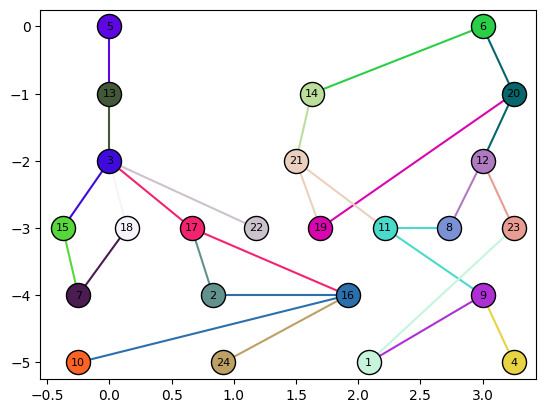

Heuristic with guarantees
Removed sinks:


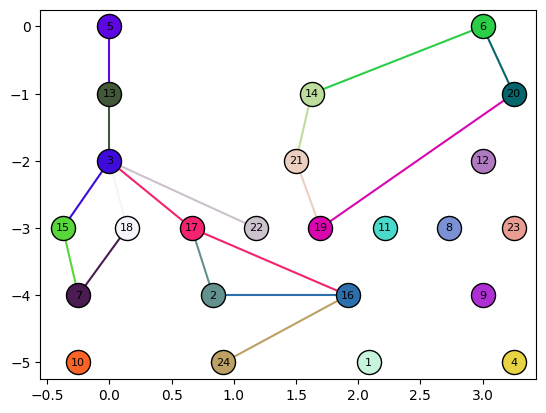

Removed sources:


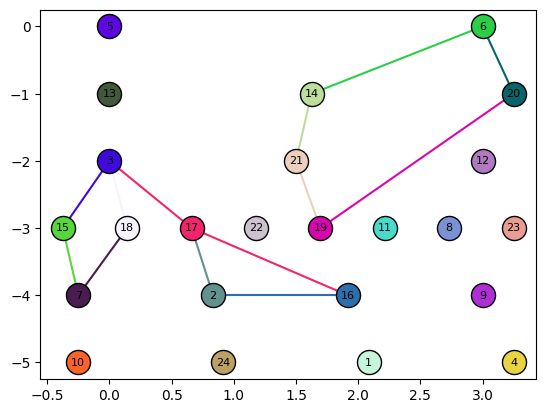

Found cycle edges


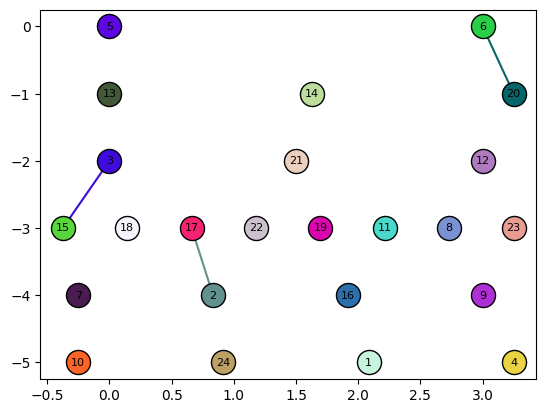

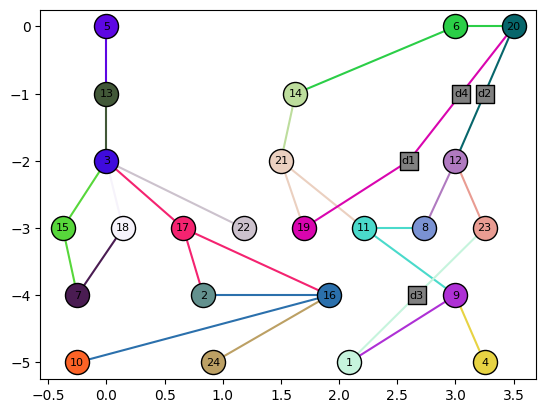

In [271]:
file_path = "D:/OneDrive - Universiteit Utrecht/Universiteit/3DataVisualisation/DataSet/noname.dot"
#LesMiserables, LeagueNetwork, polblogs, JazzNetwork, noname
nodes, edges = parse_dot_file(file_path)
main(nodes, edges, 'tree', directed_tree=True)